# **Spotify Recommender System - Project 10**


## **Introduction**

The goal of our project is to build a **recommender system** from the Song Dataset provided by **Spotify**.

In this notebook, after a brief analysis of the supplied data, we will continue by presenting the **framework** of our recommender system.
Finally we will test our work on some playlist we imported directly from Spotify.

At first we will consider how the system operates on several playlists consisting of songs of the **same** genre. Afterwards we will **merge** some of those playlists in order to test if the model can distinguish **different clusters** and suggest songs accordingly.

Before starting we need to import the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#We use requests to import data directely from Spotify
import requests

#We use json when manipulating playlist data
import json

#ast allows us to valuate a string containing a Python expression
from ast import literal_eval

## **Preliminar analysis of the dataset**

In [ ]:
#This is the main dataset cointaining all the provided songs
data = pd.read_csv('./data.csv')

Let us have a glance at the dataset in order to understand how it is structured.

In [ ]:
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


### **Features in the Dataset**


Here's a summarizing legend describing features of our dataset.

* ***acousticness*** (Float):
A measure from 0.0 to 1.0 of how much the track is acoustic.

* ***artists*** (String):
The artists who performed the track.

* ***danceability*** (Float):
Danceability describes how suitable a track is for dancing and 0.0 is the least danceable while 1.0 is the most danceable.	

* ***duration_ms*** (Integer):
The duration of the track in milliseconds.	

* ***energy*** (Float):
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.	

* ***explicit*** (Boolean):
Whether or not the track has explicit lyrics.

* ***id*** (String):
The Spotify ID for the track.	
	
* ***instrumentalness*** (Float):
Predicts whether a track contains vocals or not ina scale from 0.0 to 1.0. 

* ***key*** (Integer):
The key the track is in. (0 = C, 1 = C♯/D♭, 2 = D, and so on.)

* ***liveness*** (Float)
Detects the presence of an audience in the recording. A value above 0.8 provides strong likelihood that the track is live.	

* ***loudness*** (Float):
The overall loudness of a track in decibels (dB). Values typical range between -60 and 0 db.	

* ***mode*** (Integer):
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.	

* ***name*** (String):
The name of the track.	

* ***popularity*** (Integer):
The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.

* ***release_date*** (String):
The date the track was first released.

* ***speechiness*** (Float):
Speechiness detects the presence of spoken words in a track.	

* ***tempo*** (Float):
The overall estimated tempo of a track in beats per minute (BPM).

* ***valence*** (Float):
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.

* ***year*** (Integer):
The date the track was released. 




### Correlation Matrix

Looking at the correlation matrix we can evince which features are less correlated to the others. We will proceed not taking them into account.

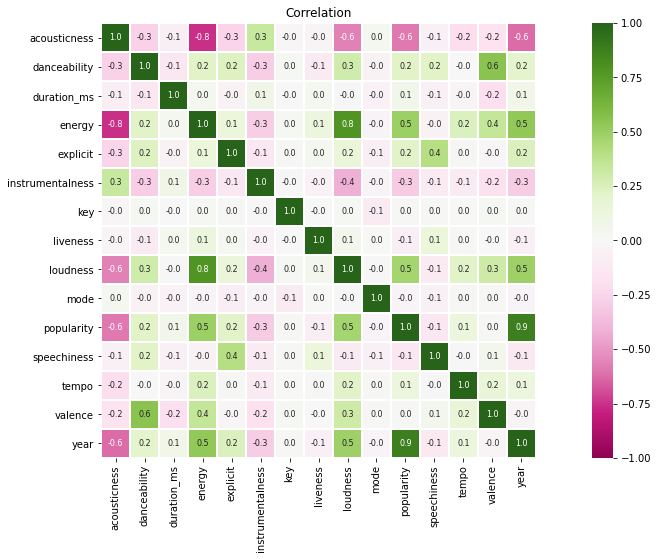

In [ ]:
from seaborn import heatmap
corr = data.corr()
plt.figure(figsize=(20,8))
heatmap(corr, vmax=1, vmin=-1, center=0,linewidth=.5,square=True, annot = True, annot_kws = {'size':8},fmt='.1f', cmap='PiYG')
plt.title('Correlation')
plt.show()

By looking at this heatmat we can notice that some features are completely **uncorrelated** from the others. We will define a *correlation threshold* that will allow us to **ignore** these features. In paricular we will exclude: `duration_ms`, `key`, `liveness`, `mode`, `speechiness`, `tempo`.




## **Creation of the Recommender System**

### **How do we take care of clustering?**

To improve our suggestions it's in our interest to **divide** the input data into **clusters**.

We handle this task in this way. At first, for each integer *n* in a prefixed interval, we calculate the *within clusters sum of squares* (wcss) of the data after we dived it in *n* clusters.

Afterwards we choose the **optimal number** of clusters *n* between these candidates. That’s where the *Elbow method* comes into action.


References: https://jtemporal.com/kmeans-and-elbow-method/

In [ ]:
def calculate_wcss(data):

  wcss = []

  for n in range(2, 10):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X=data)
    wcss.append(kmeans.inertia_)
    
  return wcss

In [ ]:
def optimal_number_of_clusters(wcss):

  x1, y1 = 2, wcss[0]
  x2, y2 = 9, wcss[len(wcss)-1]
  distances = []

  for i in range(len(wcss)):
    x0 = i+2
    y0 = wcss[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator/denominator)
    
  return distances.index(max(distances)) + 1

### **Recommender System**

The RecSys Class is the **core** of our **Recommender System**.

It consists of several methods:


*  `clean()` : used to **clean** the initial dataset. We **delete** the features with the **lowest correlation** coefficient.

*  ` user(user_data)`: it takes in **input** a **dictionary** containing the ID values of the songs listended by the user and collects them in a **Pandas Dataframe**.

*  ` cluster()`: splits the user dataframe into several **clusters** by adding a new feature that **labels** the songs.

*  ` get_artists_from_same_genre(artist)`: given an artist in input (**string**), returns a **numpy array** containing similar artists by using the dataframe *data_w_genres*.

*   `suggest(how_many = 20)`: by using the `suggest_cluster` method, returns a **Pandas Dataframe** containing the suggested songs. It can also take as input an **integer** (`how_many`) that controls how many songs are returned. This method also **labels** the suggested songs according to the cluster they refer to.

*   `suggest_cluster(songs, how_many = 20)`: this is the **core method** that handles the suggestion. It operates separately on each cluster. At first it strips the **main dataframe** using `get_artists_from_same_genre` then it assigns a **score** to each song in order to sort them and return the output.








In [ ]:
class RecSys():
    
    def __init__(self):

        self.data = pd.read_csv('./data.csv')
        self.data_w_genres = pd.read_csv('./data_w_genres.csv')
        self.clean_data = self.data.copy()
        self.songs = None # will contain the songs from the user data
        self.n = None     # will contain the number of cluster


    def clean(self):
      
        corr = self.clean_data.corr()

        for feature in corr[(abs(corr).sum() - 1) < 1.7].index:  
            del self.clean_data[feature]                           
        
        del self.clean_data['release_date']



    def user(self, user_data):

      items = user_data['tracks']['items']
      id_list = [x['track']['id'] for x in items]
      songs = self.clean_data.copy()
      self.songs = songs.loc[data['id'].isin(id_list)]



    def cluster(self):

      to_cluster = self.songs.copy()

      for x in to_cluster.columns:
        if pd.api.types.infer_dtype(to_cluster[x], skipna=True) not in ['floating','integer']:
          del to_cluster[x]

      wcss = calculate_wcss(to_cluster)
      n = optimal_number_of_clusters(wcss)
      kmeans_model = KMeans(n_clusters= n, max_iter = 600, tol = 0.00001).fit(to_cluster)
      labels = kmeans_model.labels_
      self.songs['cluster'] = labels
      self.n = n



    def get_artists_from_same_genre(self, artist):
      '''
      We look for artists that share the same genre with at least one 
      artist from the user data
      '''
      genres = literal_eval(self.data_w_genres[self.data_w_genres['artists'] == artist]['genres'].to_numpy()[0])
      artists = []

      for genre in genres:
        artists += self.data_w_genres[self.data_w_genres['genres'].str.contains('\'' + genre + '\'')]['artists'].to_list()
      
      if len(artists) == 0:
        return np.array([])
      
      artists = np.unique(artists)
      return artists



    def suggest(self, how_many = 20):
      
        s = pd.DataFrame()

        for i in range(self.n):

           cluster_suggest = self.suggest_cluster(self.songs[self.songs['cluster'] == i], how_many = how_many // (self.n))
           cluster_suggest['cluster'] = i #We label the suggestion according to the cluster they refer to

           s = s.append( cluster_suggest )
        
        return s



    def suggest_cluster(self, songs, how_many = 20): 
        
        data_user = songs.copy()

        # We select songs in a interval for the year
        year_mean = data_user['year'].mean()
        interval_start = year_mean - 2*data_user['year'].std()
        interval_end = year_mean + 2*data_user['year'].std()
        
        suggested = self.clean_data.copy()
        suggested = self.clean_data.loc[(self.clean_data['year'] >= interval_start) & (self.clean_data['year'] <= interval_end)]   
        
        # We look for the artists of the same genres of the artists in the user playlist

        similar_artist_list= []
        for list_artist in data_user['artists'].unique():
          for artist_d in literal_eval(list_artist):
            a = self.get_artists_from_same_genre(artist_d)
            if a.size != 0:
              similar_artist_list += a.tolist()
        uni = list( dict.fromkeys( similar_artist_list ) )
        sal = pd.DataFrame([(x, similar_artist_list.count(x)) for x in uni],columns = ['artist', 'count'])
        sal.sort_values(by='count', ascending=False, inplace = True)
        sal = sal['artist'][0:300].to_numpy().tolist()
        suggested = suggested[suggested['artists'].map(lambda x: bool(sum([y in sal for y in literal_eval(x)])))]
        
        # We remove duplicates
        suggested = suggested.drop_duplicates(['id'])
        suggested = suggested.drop_duplicates(['name','artists'])
        
        # We define a score over the song filtered
        # We take as score the euclidean distance from the mean of the user data songs features
        suggested['score'] = abs(suggested['acousticness']**2 - data_user['acousticness'].mean()**2) + \
                             abs(suggested['danceability']**2 - data_user['danceability'].mean()**2) + \
                             abs(suggested['energy']**2 - data_user['energy'].mean()**2) + \
                             abs(suggested['instrumentalness']**2 - data_user['instrumentalness'].mean()**2) +\
                             abs(suggested['loudness']**2 - data_user['loudness'].mean()**2)
        suggested.sort_values(by='score', ascending=True, inplace = True)

        # We delete the songs already present in the user playlist
        suggested = suggested[~(suggested['id'].isin(data_user['id'].values))]
        
        return suggested[0:how_many]

## **Importation of the playlists**

The following cells are **not** part of the **Recommender System** itself: we used this code in order to **import playlists** needed to test our system.

After having loaded the playlists from Spotify, we save them as **json** files in the folder 'playlist'. This procedure allows us to avoid importing the playlist every time we run our system.

We define `get_songs_id(playlist_id, authorization)` to **import** playlists from **Spotify** as **json** files. 

`get_songs_id` requires two input parameters: the **id** of the playlist and an **authorization token** supplied by Spotify.



More information about this procedure can be found at the following link:
[https://developer.spotify.com/documentation/general/guides/authorization-guide/](https://).


```
def get_songs_id(playlist_id, authorization):

  headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': 'Bearer ' + authorization
  }

  params = (
    ('fields', 'tracks.items(track.id)'),
  )

  response = requests.get('https://' + 'api.spotify.com/v1/playlists/' + playlist_id, headers=headers, params=params)
  
  return response.json()

```
The function `merge_playlist(p1, p2)` simply merges two playlists.
It will come in handy to test the recommender system with playlists made of different types of music.

```
def merge_playlist(p1, p2):
  api = p1['tracks']['items'] + p2['tracks']['items']
  return {'tracks':{'items':api}}
```


Once we retrive the authoriztion token we can store it here.

```
authorization = None
```



### **Imported Playlists**

Here are the **playlists** we decided to import from **Spotify**.

#### **Best of AC/DC**

`ACDC = get_songs_id('37i9dQZF1DXec50AjHrNTq',authorization)`

https://open.spotify.com/playlist/37i9dQZF1DXec50AjHrNTq?si=shNIA2iyTHS-aQfjeCBZuQ

*59 tracks*



#### **Hip Hop from the 90s**

`hip_hop_90s = get_songs_id('37i9dQZF1DX186v583rmzp', authorization)`

https://open.spotify.com/playlist/37i9dQZF1DX186v583rmzp?si=JyMSAGWHRfS_Sm9ntCwisw

*100 tracks*


#### **Rock Classics**

`rock = get_songs_id('37i9dQZF1DWXRqgorJj26U', authorization)`

https://open.spotify.com/playlist/37i9dQZF1DWXRqgorJj26U?si=UbyC59oDRNOjFTHkjRQB1g

*145 tracks*


#### **2000s Metal Classics**

`metal = get_songs_id('37i9dQZF1DWXNFSTtym834', authorization)`

https://open.spotify.com/playlist/37i9dQZF1DWXNFSTtym834?si=_UQQRyJRTXy3h12vUacvjw

*139 tracks*

#### **2010s Dance Hits**

`dance_10 = get_songs_id('37i9dQZF1DXaWf8ZIHreXF',authorization)`

https://open.spotify.com/playlist/37i9dQZF1DXaWf8ZIHreXF?si=xQe7FCdaRi2T0pmimlmuew

*99 tracks*


#### **2010s Latino**


`latino_10 = get_songs_id('37i9dQZF1DWZQkHAMKYFuV', authorization)`

https://open.spotify.com/playlist/37i9dQZF1DWZQkHAMKYFuV?si=aIFHfqTwRVuj_lvbLh1_ZA

*84 tracks*


#### **Classical Music**



`classic = get_songs_id('37i9dQZF1DWWEJlAGA9gs0', authorization)`



https://open.spotify.com/playlist/37i9dQZF1DWWEJlAGA9gs0?si=azjfnOkcSDemEvC9r7mtGg

*152 tracks*

#### **Dance + ACDC playlist**

`dance_and_ACDC = merge_playlist(dance_10, ACDC)`


#### **Playlist Rock + Metal**

`rock_and_metal = merge_playlist(ACDC, metal)`


#### **Classic + Latino**

`classic_and_latino = merge_playlist(latino_10, classic)`



#### **Rock + Latino + Classic**

`rock_latino_classic = merge_playlist(classic_and_latino, rock)`



### **Saving playlists in a .json file**

This is the snippet of code we used to save playlists in a json file.
```
with open('dance_and_ACDC.json', 'w') as json_file:
    json.dump(dance_and_ACDC, json_file)
```



### **Loading playlists from the .json file**

Now, we **upload** from the folder 'playlist' the playlists we previously stored. For convenience, we save this playlist in a dictionary named `playlist` where the keys are the names of the playlist and the values are the playlist themselves.

In [ ]:
from os import listdir

data_path = './playlist/'
fpaths = []
for f in listdir(data_path):
  fpaths.append(f)

playlist = {}
for p in fpaths:
  with open(data_path + p) as json_file:
    playlist[p.replace('.json','')] = json.load(json_file)

In [ ]:
playlist.keys()

dict_keys(['dance_and_ACDC', 'latino_10', 'rock', 'hip_hop_90s', 'rock_90s', 'rock_and_metal', 'metal', 'ACDC', 'rock_latino_classic', 'classic', 'classic_and_latino', 'dance_10'])

## **Testing of our system on real playlists**


In order to retrieve suggestions from users data, we implement the function 
`return_suggest(user_data, how_many)`. This function takes as input the user data, a **Pandas Dataframe**, and the number of suggested songs we want to return.
The function creates a RecSys class object and returns the suggested songs for the user data provided.

In [ ]:
def return_suggest(user_data, how_many = 20):
  rs = RecSys()
  rs.clean()
  rs.user(user_data)
  rs.cluster()
  return rs.suggest(how_many)

To better understand the suggestion output, we can refer to the label `cluster`. Indeed, if we look at this marker we can notice how suggestion belonging to the same cluster are **relevant** and **distinct** from the other ones.


### **2010s Dance Hits**

In [ ]:
dance = return_suggest(playlist['dance_10'])

In [ ]:
dance

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
39563,0.02810,['Kid Ink'],0.562,0.682,1,0Altlm3kLPob56k2qqR4i2,0.000045,-5.883,Money and the Power,57,0.385,2014,0.297199,0
15110,0.00320,['Miley Cyrus'],0.684,0.675,0,3RfNQMIeuL2QC9l4VxOMoj,0.000465,-5.886,Dream,48,0.846,2009,0.327945,0
97634,0.12100,"['NOTD', 'Felix Jaehn', 'Captain Cuts', 'Georg...",0.700,0.872,0,7FjZU7XFs7P9jHI9Z0yRhK,0.000007,-5.896,So Close,77,0.761,2018,0.340726,0
116194,0.01510,['Nick Jonas'],0.589,0.611,0,5Eg4TsPcqNbIjd8ADMZosg,0.000000,-5.881,Chains,61,0.121,2015,0.380891,0
47537,0.08560,"['Matoma', 'Astrid S']",0.601,0.682,0,2H8LPaY3NSjmOFMH2Rygnz,0.003840,-5.905,Running Out,58,0.170,2015,0.384298,0
15204,0.00237,"['Swedish House Mafia', 'Tinie Tempah']",0.736,0.929,1,5ZFVacinyPxz19eK2vTodL,0.000011,-5.890,Miami 2 Ibiza - Swedish House Mafia vs. Tinie ...,48,0.658,2010,0.409785,0
39408,0.12900,"['Minnesota', 'Zion I']",0.655,0.869,0,3KVp3xFBemY9Z4O7vYNfuf,0.000000,-4.348,Float (feat. Zion I),46,0.733,2012,0.123142,1
40165,0.01190,['Niall Horan'],0.591,0.841,0,0DrFTaAX2srXPkuag35djb,0.000000,-4.351,Nice To Meet Ya,70,0.392,2020,0.151305,1
23667,0.00857,['Little Mix'],0.697,0.841,0,4z0sS7hwnTZTRKZVahth6J,0.000044,-4.339,Hair,65,0.697,2015,0.164536,1
55289,0.01570,"['BTS', 'Desiigner', 'Steve Aoki']",0.613,0.842,0,7Ed6BkggCS2KaKY5YlINaF,0.000000,-4.332,MIC Drop (feat. Desiigner) [Steve Aoki Remix],63,0.645,2017,0.195710,1


### **Hip Hop from the 90s**

In [ ]:
hip_hop = return_suggest(playlist['hip_hop_90s'])

In [ ]:
hip_hop

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
85408,0.002950,"['Bone Thugs-N-Harmony', 'Eazy-E']",0.772,0.695,1,1muLq1kBLWIT3pmNC2xl0g,0.000000,-8.013,Foe Tha Love of $,60,0.643,1994,0.204000,0
167550,0.000431,['Wu-Tang Clan'],0.688,0.725,1,1mxXB3Vsaaw9goChMrQuiK,0.000393,-8.032,The M.G.M.,43,0.560,1997,0.366220,0
5764,0.000238,['Wu-Tang Clan'],0.592,0.721,1,2b3gxK2X5nI7c0NSRFFDBm,0.015200,-8.011,The City,42,0.297,1997,0.518622,0
37968,0.008070,"['Monica', '112']",0.529,0.481,0,6jw6FmzPpfZmp0wHR65lGJ,0.000035,-8.027,Right Here Waiting (feat. 112),40,0.140,1998,0.623074,0
37804,0.322000,['Westside Connection'],0.849,0.790,1,4UVDkvVId0sStwp8WaddFo,0.000000,-8.045,Westward Ho,33,0.603,1996,0.744778,0
52873,0.012300,"[""Compton's Most Wanted""]",0.778,0.594,0,3ggnEg5IQhWV2hUbaDANcU,0.019700,-9.561,N 2 Deep,33,0.635,1992,0.154688,1
114251,0.001200,['LL Cool J'],0.632,0.613,0,77nTnRGCyI8NNZUcgjShjg,0.000001,-9.553,I'm Bad,52,0.726,1996,0.262867,1
75762,0.012000,['Scarface'],0.839,0.637,1,6VixF2QhUqNgcbH9SujeiQ,0.000994,-9.563,Southside,32,0.475,1997,0.312590,1
21203,0.025700,['Geto Boys'],0.753,0.691,1,3Oq6RiCjkftGA5Ljwwm6d0,0.000000,-9.565,Mind of a Lunatic,32,0.856,1990,0.358005,1
53423,0.067700,['Devin The Dude'],0.708,0.615,1,14ihvXob4BVmsftJKtLeNs,0.000017,-9.574,Boo Boo’n,34,0.469,1998,0.492822,1


### **2000s Metal Classics**

In [ ]:
metal = return_suggest(playlist['metal'])

In [ ]:
metal

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
124316,0.002220,['Sum 41'],0.440,0.919,1,3SO0vfryYv381w1ImgWONG,0.005030,-4.462,Over My Head (Better Off Dead),48,0.773,2002,0.119626,0
53615,0.000018,['Spineshank'],0.480,0.925,0,2xV28mhkI7AzwpJEqPGSb3,0.000009,-4.449,Synthetic,40,0.460,2000,0.122064,0
14610,0.000099,['Breaking Benjamin'],0.462,0.871,1,2lpcY0lROi0khLsnBCMp1W,0.000000,-4.448,Simple Design,43,0.509,2004,0.124643,0
38650,0.004410,['Theory of a Deadman'],0.395,0.893,0,06hNjTThF575UgFeWq2VTZ,0.000000,-4.450,Say Goodbye,42,0.436,2005,0.125446,0
69388,0.000233,['Disturbed'],0.494,0.949,0,0lOonb8Xn49VXJ1Ukb2vgh,0.003540,-4.452,Enough,45,0.637,2008,0.153960,0
152032,0.000057,['Breaking Benjamin'],0.390,0.958,0,5m9uiFH9sK5wxRZdfN62n9,0.043700,-4.455,The Diary Of Jane,51,0.348,2011,0.176961,0
76277,0.005890,['Mushroomhead'],0.479,0.897,0,2Z4TvtOTxVmE0RDlMIxJqc,0.000271,-4.327,Nowhere To Go,39,0.424,2003,0.116139,1
30925,0.000025,['Chevelle'],0.447,0.917,0,3booZW0BKQ8En18KSxsZPr,0.037400,-4.332,The Fad,43,0.340,2007,0.117866,1
61226,0.000360,['Sum 41'],0.467,0.955,0,46pErPIiLjAWrr5uLFomA0,0.000000,-4.326,Summer,45,0.754,2000,0.156732,1
134260,0.001590,['Hollywood Undead'],0.522,0.931,0,5koyOdvQU9AUgPMA14N4mD,0.000000,-4.320,Young,51,0.367,2008,0.164608,1


### **Best of AC/DC**

In [ ]:
ACDC = return_suggest(playlist['ACDC'])

In [ ]:
ACDC

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
122282,0.008000,['Rick Springfield'],0.454,0.891,0,0q9kwsDddMpLd5PVctArlK,0.000003,-4.851,Love Is Alright Tonite,35,0.800,1981,0.214087,0
59744,0.176000,['R.E.M.'],0.515,0.809,0,2q5WqgivCVnCxKXVbNzWs0,0.012400,-4.864,Green Grow The Rushes - Remastered,25,0.537,1985,0.248695,0
36433,0.000937,['Tom Petty and the Heartbreakers'],0.484,0.906,0,1BbMhfUaNtdpwoHaCuPVhC,0.000503,-4.857,A One Story Town,25,0.827,1982,0.271212,0
28767,0.032300,['Peter Gabriel'],0.584,0.921,0,36a311Jq8qByai9eCwpzo1,0.000001,-4.850,Solsbury Hill - Live,24,0.435,1986,0.282502,0
44631,0.000490,['The Smiths'],0.513,0.907,0,66xHkdUeQUaCTT9JmSHtqy,0.035900,-4.840,The Queen Is Dead - Full Version,33,0.641,1986,0.284918,0
74625,0.310000,['The Smiths'],0.515,0.899,0,7h2ErP3kwgbLbFsBHWLkS0,0.000215,-4.847,The Boy with the Thorn in His Side - Demo Mix,31,0.765,1986,0.292103,0
38124,0.000120,['Staind'],0.511,0.820,0,4eC8kxde5otdG8EyoMQXhG,0.003990,-4.509,A Flat,38,0.366,1999,0.118526,1
37758,0.067200,['Van Halen'],0.526,0.891,0,7E8sTX79VcbCaWnCu3jsko,0.000000,-4.508,Dance the Night Away,37,0.689,1996,0.184041,1
61877,0.011700,['Rob Zombie'],0.627,0.847,0,61u3kwCoVSdYc8DH7JQZlN,0.000000,-4.497,"Foxy, Foxy",42,0.620,2006,0.187378,1
159572,0.000079,"['Rob Zombie', 'Ozzy Osbourne']",0.527,0.924,0,1BTpL8k7DytUPa2sNYs53P,0.067400,-4.503,Iron Head,46,0.324,2001,0.188848,1


### **Rock Classics**

In [ ]:
rock = return_suggest(playlist['rock'])

In [ ]:
rock

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
93020,0.277000,['Steely Dan'],0.641,0.643,0,3Hp7HkYTFxzMrTJdPXQJI6,0.000000,-10.273,Midnite Cruiser,48,0.720,1972,0.261266,0
66036,0.177000,['Harry Nilsson'],0.498,0.518,0,6INhEZ4gf6eCPiyaG4O1N7,0.009830,-10.273,Save the Last Dance for Me,21,0.601,1974,0.280858,0
102430,0.049400,['John Lennon'],0.585,0.517,0,7xsr2OppItxPB4whucYr2G,0.023500,-10.269,How Do You Sleep? - Remastered 2010,50,0.714,1971,0.284266,0
82945,0.367000,['Van Morrison'],0.608,0.524,0,3lh3iiiJeiBXHSZw6u0kh6,0.002540,-10.266,Into the Mystic - 2013 Remaster,73,0.797,1970,0.291562,0
10950,0.047100,['Simon & Garfunkel'],0.543,0.564,0,0ukMJRQa8UoAbtNVIhEgYE,0.000000,-10.260,The Big Bright Green Pleasure Machine - Altern...,29,0.846,1968,0.371618,0
73911,0.323000,['Jefferson Starship'],0.556,0.744,0,5Hm2mG4y5ktE548UmkmlBm,0.000007,-8.628,Lightning Rose,23,0.569,1979,0.217388,1
28892,0.000761,['R.E.M.'],0.565,0.748,0,0hwxPHS9l7oHIQ5nFllsct,0.000060,-8.638,Strange,31,0.848,1987,0.276805,1
65743,0.177000,"[""Howlin' Wolf"", 'Eric Clapton', 'Steve Winwoo...",0.705,0.722,0,0BsydjW56k7N8Ri63bXp9v,0.000017,-8.638,Wang Dang Doodle,24,0.753,1971,0.304886,1
12436,0.013900,['Duran Duran'],0.575,0.860,0,7bnUEysVUvlkJekYgjaz3U,0.000007,-8.628,Lonely in Your Nightmare - 2001 Remaster,25,0.773,1982,0.337644,1
113093,0.002400,['Talking Heads'],0.600,0.921,0,0E3gdEF4z9cBFfFqA7i72k,0.059900,-8.631,Thank You for Sending Me an Angel - Live,44,0.634,1984,0.368683,1


### **2010s Latino**

In [ ]:
latino_10 = return_suggest(playlist['latino_10'])

In [ ]:
latino_10

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
144271,0.03250,['Myke Towers'],0.733,0.708,1,43NqTeL8pgBxKHPMiJKUP5,0.000327,-4.957,Girl,80,0.6940,2020,0.180416,0
97829,0.32100,"['Bad Bunny', 'Nicky Jam']",0.590,0.729,1,5bmSver2b3ZXyuyLKtgnFI,0.000000,-4.950,BAD CON NICKY,85,0.7120,2020,0.210284,0
23819,0.13400,['Sebastian Yatra'],0.776,0.684,0,79Jhw5xn4gGn6PZak275gg,0.000000,-4.950,Traicionera,65,0.6580,2016,0.225923,0
152677,0.05610,"['Nicky Jam', 'J Balvin', 'Maluma', 'Ozuna']",0.663,0.696,0,6JjPBQfI2Y8nIjnm65X6Pw,0.000038,-4.957,X (feat. Maluma & Ozuna) - Remix,71,0.7380,2018,0.239188,0
77514,0.22100,"['Zion & Lennox', 'Farruko', 'Yandel']",0.716,0.795,0,7dnOGJWp5Mspq4drP0oaxZ,0.000000,-4.930,Pierdo la Cabeza - Remix,61,0.6660,2015,0.371060,0
106123,0.00758,['Arcangel'],0.897,0.755,0,1pLCpA1RN8avJxSD3ZCwhj,0.000451,-5.684,Pa' Que La Pases Bien,65,0.5670,2008,0.300071,1
54630,0.19800,"['Wisin & Yandel', 'Cosculluela', 'Tego Calder...",0.845,0.845,0,6LgGKcMoXvDtKgAp2znkKQ,0.000001,-5.674,La Reunión De Los Vaqueros,53,0.6620,2010,0.383680,1
62032,0.27500,"['Héctor ""El Father""']",0.802,0.873,0,5QpUAyROQsLtNLPY5TJcFv,0.000003,-5.698,Tu Quieres Duro,48,0.0933,2008,0.461340,1
168863,0.26000,['Intocable'],0.614,0.834,0,1iEu0w8EG4xkNpmzzy4SyP,0.000000,-5.705,Eres Mi Droga,58,0.9620,2010,0.577972,1
15386,0.23400,['Cali Y El Dandee'],0.481,0.810,0,0mGvaKpwLYoybnIoboC3uS,0.000000,-5.704,Yo Te Esperaré,69,0.3280,2012,0.659898,1


### **Classical Music**


In [ ]:
classic = return_suggest(playlist['classic'])

In [ ]:
classic

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
159355,0.903,"['Johannes Brahms', 'Budapest Festival Orchest...",0.3490,0.05030,0,2cFsO1qC65joLn2GzRViBI,0.1530,-18.668,"Hungarian Dance No.5 in G Minor, WoO 1, No.5",45,0.2950,1999,0.633725,0
75892,0.413,"['Richard Strauss', 'London Philharmonic Orche...",0.1570,0.17500,0,41kd6nWfxAytm08XVujL7q,0.8560,-18.829,Also Sprach Zarathustra Op.30: Einleitung (Ope...,46,0.0348,1999,7.176030,0
54164,0.925,"['John Williams', 'London Symphony Orchestra']",0.0604,0.14700,0,2Tlv01jTgfA79TGMFrJx1O,0.7830,-18.954,The Birth of the Twins and Padmé's Destiny,44,0.0364,2005,11.211430,0
69165,0.857,"['John Williams', 'London Symphony Orchestra']",0.1200,0.13300,0,00sPWXrRQtyGn9BqoPbMCd,0.8670,-18.955,Grievous Speaks to Lord Sidious,43,0.0616,2005,11.399995,0
142453,0.984,"['Dmitri Shostakovich', 'Russian State Symphon...",0.3220,0.18400,0,0pjCsB0XNSyqM9UazlTODC,0.9020,-18.312,Jazz Suite No. 2: VI. Waltz 2,57,0.3560,2002,13.591146,0
120162,0.967,"['Franz Liszt', 'Arthur Rubinstein', 'Alfred W...",0.3720,0.27700,0,2LOQtnSs1l1uSycL81qFGk,0.5910,-15.712,"Piano Concerto No. 1 in E-Flat Major, S. 124: ...",28,0.3440,1960,0.407411,1
72188,0.950,"['Johannes Brahms', 'Leonard Bernstein', 'New ...",0.2100,0.12700,0,2gVosfWiwg4lgWsz0iyGjm,0.9300,-15.720,"Symphony No. 2 in D Major, Op. 73: I. Allegro ...",7,0.0492,1962,0.557158,1
18335,0.959,"['Franz Liszt', 'Eugene Ormandy', 'Philadelphi...",0.2260,0.27700,0,1gpeMAPezSngNlVWHmHisQ,0.8530,-15.727,"2 Episoden aus Lenau's Faust, S. 110: No. 2, D...",15,0.0648,1961,0.672656,1
49899,0.926,"['Anton Rubinstein', 'Isaac Stern', 'Frank Bri...",0.1240,0.14300,0,0lqbiUXCJa13jUeKWBLzR7,0.5420,-15.743,"Romance in E-Flat Major, Op. 44, No. 1",17,0.1390,1963,0.880112,1
41394,0.979,"['Robert Schumann', 'Guido Cantelli', 'Philhar...",0.3560,0.12000,0,0bgs0OuahDSJCgNXogT4vl,0.9180,-15.707,"Schumann: Symphony No. 4 in D Minor, Op. 120: ...",0,0.2030,1954,1.040007,1


### **2010 Dance Hits and Best of AC/DC**

In [ ]:
dance_and_ACDC = return_suggest(playlist['dance_and_ACDC'])

In [ ]:
dance_and_ACDC

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
59744,0.176000,['R.E.M.'],0.515,0.809,0,2q5WqgivCVnCxKXVbNzWs0,0.012400,-4.864,Green Grow The Rushes - Remastered,25,0.537,1985,0.289266,0
4803,0.040100,['R.E.M.'],0.689,0.826,0,7GEQic2y8KjVONDyRvZgCK,0.000000,-4.877,Exhuming McCarthy - Remastered,38,0.967,1987,0.312405,0
103882,0.071100,['R.E.M.'],0.432,0.852,0,3xPKSMgZl4N3rfTyIgSPfa,0.000391,-4.865,Fall On Me - 2011 Remaster,48,0.596,1986,0.327917,0
113383,0.000108,['The Smiths'],0.406,0.926,0,38ZW90yqTca2NYmh3uy4xV,0.013600,-4.875,Girl Afraid - 2011 Remaster,49,0.911,1987,0.383752,0
13117,0.005910,['Red Hot Chili Peppers'],0.537,0.949,0,6cvDm4TzE9Rartsazd63S5,0.000898,-4.871,Sexy Mexican Maid - Remastered,36,0.564,1989,0.384150,0
13289,0.000033,['Nirvana'],0.436,0.876,0,0pas4o8x1kHxc5VnPWZqFG,0.000104,-4.902,In Bloom - Nevermind Version,32,0.512,1991,0.389640,0
116110,0.000629,['Tiësto'],0.654,0.830,0,5L2l7mI8J1USMzhsmdjat9,0.000001,-4.801,Red Lights,68,0.548,2014,0.125906,1
8124,0.356000,"['Kygo', 'Joe Janiak']",0.630,0.826,0,4gGIqmBDfECUFBOSYOoW3a,0.000007,-4.798,Follow,69,0.239,2020,0.190223,1
152205,0.002470,['Avicii'],0.586,0.727,0,1CKtxKqyFsFITCH4SpDrWj,0.010700,-4.799,You Make Me,66,0.496,2013,0.205700,1
87477,0.021500,['Flo Rida'],0.688,0.702,0,6Knv6wdA0luoMUuuoYi2i1,0.000000,-4.792,My House,76,0.740,2015,0.260670,1


### **Classical and Latino**

In [ ]:
ch = return_suggest(playlist['classic_and_latino'])

In [ ]:
ch

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
8145,0.0587,"['Anuel AA', 'Tego Calderon']",0.7130,0.7700,1,2WzUy86kPLYRLRwLtinZ1x,0.000501,-4.779,Rifles Rusos,71,0.6840,2020,0.207035,0
134629,0.2310,"['Alexis y Fido', 'Franco ""El Gorilla""']",0.7110,0.8410,0,3tI4duDhHmmz1Sp7RX0Jbq,0.000098,-4.775,Mala Conducta (feat. Franco El Gorila),63,0.9640,2011,0.289628,0
126101,0.1980,"['Luis Fonsi', 'Daddy Yankee']",0.6550,0.7970,0,6habFhsOp2NvshLv26DqMb,0.000000,-4.787,Despacito,79,0.8390,2019,0.369458,0
116671,0.0411,"['Rvssian', 'Anuel AA', 'Juice WRLD']",0.6800,0.7660,0,2AuWgceaQyfMoI3EGavwGb,0.000000,-4.799,No Me Ame,78,0.2800,2020,0.440177,0
107198,0.0170,"['Tainy', 'Anuel AA', 'Ozuna']",0.7340,0.8360,0,3jbT1Y5MoPwEIpZndDDwVq,0.000016,-4.803,Adicto (with Anuel AA & Ozuna),83,0.6230,2019,0.515769,0
55685,0.2550,"['El Alfa', 'Lil Pump', 'Sech', 'Myke Towers',...",0.8830,0.8530,0,047WmwIeerHyIUstFAEz5A,0.000723,-4.773,Coronao Now (Remix),73,0.6950,2020,0.523008,0
37835,0.9720,"['Fritz Kreisler', 'Joshua Bell', 'Paul Coker']",0.2240,0.0549,0,4PAwFMCI2N0tPqAoX0lBnt,0.648000,-25.496,Liebesleid,42,0.1520,1996,0.883073,1
39311,0.9920,"['Frédéric Chopin', 'Vladimir Feltsman']",0.3090,0.0472,0,6qUjY7JsuQYxn99qfOAQyB,0.866000,-25.497,"Nocturne in E-Flat Major, Op. 9, No.2",54,0.0693,2011,1.099960,1
23182,0.9680,"['Sergei Rachmaninoff', 'Valery Gergiev', 'Mar...",0.1230,0.0386,0,7EcjtjNYDhQ82yCQZU0Z9C,0.939000,-25.577,"Rhapsody On a Theme of Paganini, Op. 43: V. Va...",55,0.0573,2010,3.939010,1
95587,0.9910,"['Franz Liszt', 'Jenő Jandó']",0.3430,0.0342,0,6GzMz3s0K1YKwRVI36CgRx,0.920000,-25.591,"Liebestraume, S541/R211 : No. 3: Nocturne in A...",62,0.0378,1998,4.679160,1


### **Rock, Latino and Classical**

In [ ]:
rlc = return_suggest(playlist['rock_latino_classic'])

In [ ]:
rlc

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score,cluster
19627,0.4500,['Bad Company'],0.531,0.588,0,4LRiNOcB9fWg0SwhCPf5yB,0.005160,-9.493,"Little Miss Fortune - B-Side of ""Can't Get Eno...",25,0.7050,1974,0.254275,0
2841,0.3520,['The Beatles'],0.597,0.660,0,33M8Tg2vvZYsmJIuGa3zZd,0.009130,-9.499,Sgt. Pepper's Lonely Hearts Club Band - Take 9...,29,0.5560,1967,0.264398,0
164155,0.2320,['The Beach Boys'],0.608,0.606,0,3N2HzHr1mCOJj6DzdLdX30,0.000004,-9.484,South Bay Surfer (Mono),19,0.9670,1963,0.333195,0
148284,0.3310,['The Who'],0.469,0.494,0,75AhlGB9aFWTxDfbmbdiCH,0.000000,-9.495,Cut My Hair,31,0.4080,1973,0.363047,0
139973,0.0185,['10cc'],0.737,0.642,0,1fMGRxKRtIKNyaMMGrzInM,0.004150,-9.492,Good Morning Judge,45,0.4670,1977,0.363429,0
28059,0.1710,['David Bowie'],0.523,0.495,0,7GUqTaobt7S0eQp6QXE4dE,0.000003,-9.499,Yassassin - Turkish For: Long Live; 2017 Remaster,33,0.7460,1979,0.376012,0
111161,0.2950,['The Byrds'],0.496,0.701,0,46uLYXCBGVCkAFLV6YH2PQ,0.000111,-9.506,It Won't Be Wrong,34,0.8600,1965,0.377214,0
44034,0.2770,['Steve Winwood'],0.709,0.515,0,4cb4G2AmsubdfoqdD4p0TF,0.000193,-9.493,Slowdown Sundown,27,0.5690,1980,0.420001,0
102156,0.0722,['The Beatles'],0.587,0.431,0,2ck8lFrYAch2GPtdhpTHe3,0.000000,-9.495,All Together Now - Remastered 2009,47,0.7780,1969,0.427736,0
65473,0.1900,['The Who'],0.383,0.744,0,2JfJkTJOOBP5ZF7dp3XFr3,0.000355,-9.484,Overture - Live / Including Introduction,23,0.1690,1969,0.447338,0


## **Conclusions**

Looking at the suggestions based on **one-genre** playlists we observed that the tracks are similar to what we expected, since they are not far from the musical taste of the user. 

We noticed that there is **balance** between artists already known by the user and artists that are not present in the original playlist. In this way, our system allows the user to come in touch with tracks he would have not discover otherwise.

From our testing with **merged playlists** we noticed that our system manages to identify different genres and suggests songs accordingly. The system misclassifies songs **rarely** and even in these occasions this does not interfere with a **coherent** suggestion output.
